In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from torch.nn import functional as F
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 40
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset.data.transpose((0, 3, 1, 2))  # Change data to (batch-size, channels, height, width)
        self.targets = dataset.targets
        self.data = self.data / 255.0
        self.data = torch.tensor(self.data).float()

    def __getitem__(self, index):
        # anchor is the input data
        anchor, anchor_label = self.data[index], self.targets[index]
        # positive is the same label as data
        positive_indices = [i for i, t in enumerate(self.targets) if t == anchor_label and i != index]
        # negetive is not the same label as data
        negative_indices = [i for i, t in enumerate(self.targets) if t != anchor_label]
        # select randomly from ps and neg
        positive = self.data[random.choice(positive_indices)]
        negative = self.data[random.choice(negative_indices)]
        return anchor, positive, negative , anchor_label

    def __len__(self):
        return len(self.data)


# Load the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include the 'airplane' and 'automobile' classes
indices = [i for i, label in enumerate(dataset.targets) if label in [0, 1]]  
dataset.data = dataset.data[indices]
dataset.targets = [dataset.targets[i] for i in indices]

# Create the TripletDataset
triplet_dataset = TripletDataset(dataset)
trainloader = torch.utils.data.DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
test_indices = [i for i, label in enumerate(testset.targets) if label == 0 or label == 1]
testset.targets = [testset.targets[i] for i in test_indices]
testset.data = testset.data[test_indices]

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=0)


100%|██████████| 170498071/170498071 [00:04<00:00, 41567932.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


4
torch.Size([40, 3, 32, 32])


Text(0.5, 1.0, 'negatives')

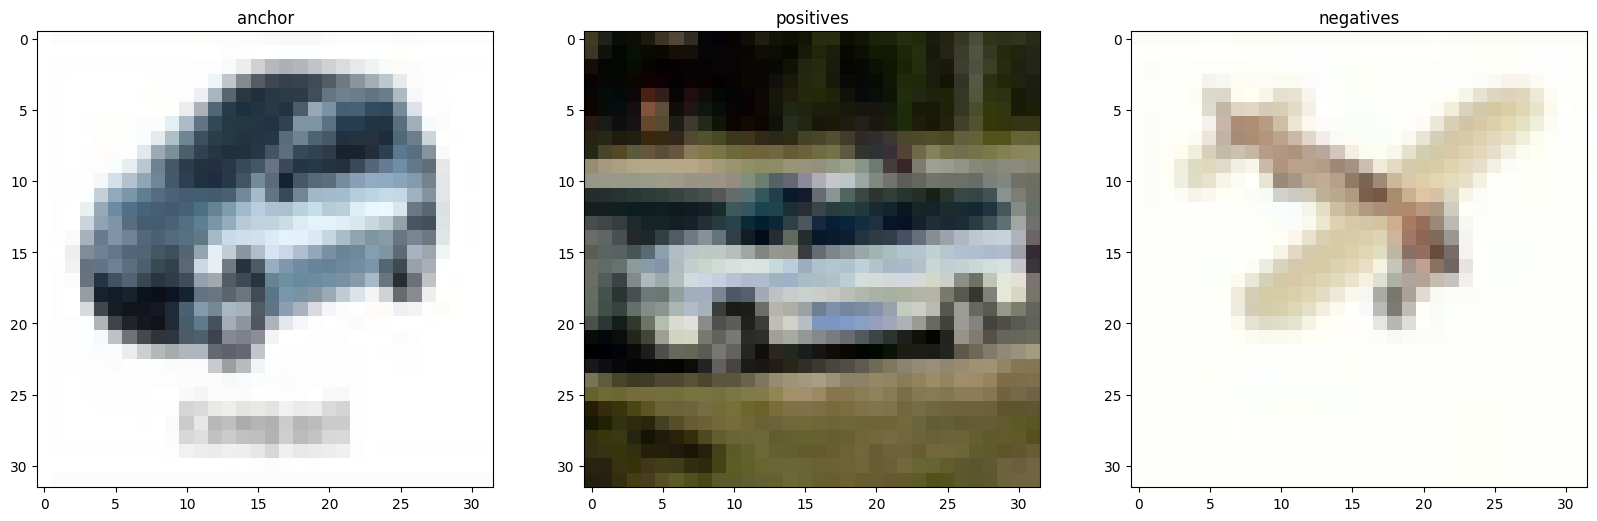

In [4]:
# show three images of first itteration
for i, data in enumerate(trainloader, 0):
    print(len(data))
    anchors, positives, negatives ,_ = data
    print(anchors.shape)
    break
_,axes = plt.subplots( 1,3 , figsize=(20, 10))
i = random.randint(0, batch_size-1)
anchors = anchors.permute(0,2, 3, 1)
axes[0].imshow(anchors[i])
axes[0].set_title(f'anchor')
positives = positives.permute(0,2, 3, 1)
axes[1].imshow(positives[i])
axes[1].set_title('positives')
negatives = negatives.permute(0,2, 3, 1)
axes[2].imshow(negatives[i])
axes[2].set_title('negatives')


In [5]:
# define TripletLoss class
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [6]:
model = torchvision.models.resnet50(pretrained=True)

# define a Fc layer with 2 output
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)


# devide model to Fc layer and the feature_extractor network
# feature_extractor network
model_Feature = torch.nn.Sequential(*list(model.children())[:-1])

# fullt connected network
model_fc = model.fc

# freeze FC model
for param in model_fc.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.8MB/s]


In [7]:
criterion_Feature = TripletLoss()
optimizer_Feature = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train feature extractor

In [9]:
number_of_epoch = 10
loss_values = []
accuracy_values = []
for epoch in (range(number_of_epoch)):   # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0
    for anchors, positives, negatives,anchor_label in tqdm(trainloader, 0):
        # get the inputs; data is a list of [anchors, positives, negatives]
        # zero the parameter gradients
        optimizer_Feature.zero_grad()

        # forward + backward + optimize
        # pass anchors
        anchor_temp = model_Feature(anchors)
        anchor_output = model_fc(anchor_temp.view(anchor_temp.size(0), -1))
        # pass positives
        positive_temp = model_Feature(positives)
        positive_output = model_fc(positive_temp.view(positive_temp.size(0), -1))
        # pass negatives
        negative_temp = model_Feature(negatives)
        negative_output = model_fc(negative_temp.view(negative_temp.size(0), -1))
        # calculate loss
        loss = criterion_Feature(anchor_temp, positive_temp, negative_temp)
        # optimize
        loss.backward()
        optimizer_Feature.step()

        # statistics
        running_loss += loss.item()

        # pridiction
        total += anchors.size(0)
        _, predicted = torch.max(anchor_output.data, 1)

        correct += (predicted == anchor_label).sum().item()

    loss_values.append(running_loss / total)
    accuracy_values.append(100 * correct / total)

    print(f'ecpoch:{epoch+1}, loss:{running_loss/ total}, accuracy:{100 * correct / total}')

print('Finished Training')

100%|██████████| 250/250 [11:47<00:00,  2.83s/it]


ecpoch:1, loss:0.00795426164418459, accuracy:50.05


100%|██████████| 250/250 [11:45<00:00,  2.82s/it]


ecpoch:2, loss:0.0063411044582724575, accuracy:49.99


100%|██████████| 250/250 [11:41<00:00,  2.80s/it]


ecpoch:3, loss:0.004935678417980671, accuracy:50.0


100%|██████████| 250/250 [11:50<00:00,  2.84s/it]


ecpoch:4, loss:0.00408030249029398, accuracy:50.0


100%|██████████| 250/250 [11:53<00:00,  2.85s/it]


ecpoch:5, loss:0.0035674656979739665, accuracy:50.0


100%|██████████| 250/250 [11:51<00:00,  2.85s/it]


ecpoch:6, loss:0.0032404480576515198, accuracy:50.0


100%|██████████| 250/250 [11:53<00:00,  2.85s/it]


ecpoch:7, loss:0.002909255702793598, accuracy:50.0


100%|██████████| 250/250 [11:59<00:00,  2.88s/it]


ecpoch:8, loss:0.0027927699603140354, accuracy:49.99


100%|██████████| 250/250 [11:48<00:00,  2.84s/it]


ecpoch:9, loss:0.0025558973055332898, accuracy:50.0


100%|██████████| 250/250 [11:36<00:00,  2.78s/it]

ecpoch:10, loss:0.002484262902289629, accuracy:50.01
Finished Training


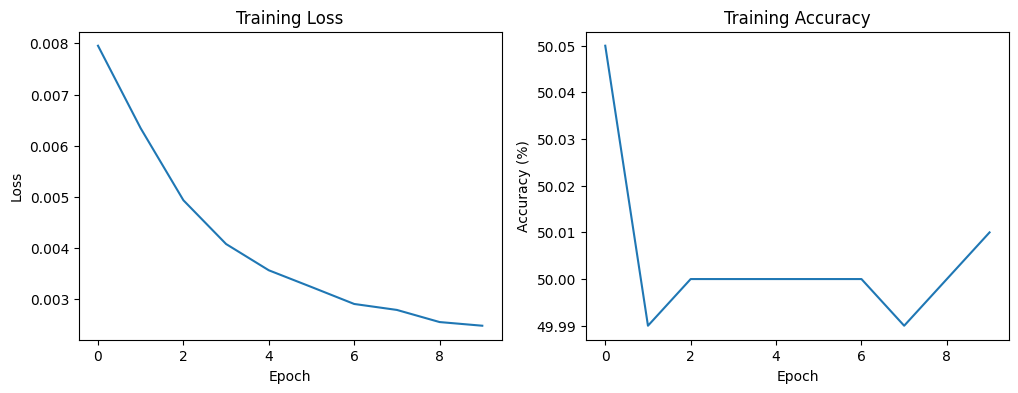

In [10]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

here accuracy dosen't have any sense but I plot it

Train fully connected network

In [11]:
# unfreeze FC model
for param in model_fc.parameters():
    param.requires_grad = True

# freeze feature extractor model
for param in model_Feature.parameters():
    param.requires_grad = False



In [12]:
criterion_fc= torch.nn.CrossEntropyLoss()
optimizer_fc = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
number_of_epoch = 10
loss_values = []
accuracy_values = []
for epoch in tqdm(range(number_of_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        anchors, positives, negatives, labels = data  # the input size is (batch_size , 3 , 32 ,32)
        # zero the parameter gradients
        optimizer_fc.zero_grad()
        # print(enchores.shape)
        # pass the input from the freezed model(feature extractor)

        in_temp = model_Feature(anchors)
        # pass the output of the freezed model to the fc layer
        outputs = model_fc(in_temp.view(in_temp.size(0), -1))

        # optimize the fc layer
        loss = criterion_fc(outputs, labels)
        loss.backward()
        optimizer_fc.step()

        # print statistics
        running_loss += loss.item()

        # pridiction
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        # print('loss:',loss)

    loss_values.append(running_loss / total)
    accuracy_values.append(100 * correct / total)

    print(f'ecpoch:{epoch+1}, loss:{running_loss/ total}')

print('Finished Training')


 10%|█         | 1/10 [01:25<12:51, 85.70s/it]

ecpoch:1, loss:0.0005595702154525497


 20%|██        | 2/10 [02:49<11:18, 84.84s/it]

ecpoch:2, loss:0.00035762684828951024


 30%|███       | 3/10 [04:14<09:52, 84.58s/it]

ecpoch:3, loss:0.0003021230257698335


 40%|████      | 4/10 [05:37<08:25, 84.22s/it]

ecpoch:4, loss:0.0003699170960695483


 50%|█████     | 5/10 [07:03<07:03, 84.75s/it]

ecpoch:5, loss:0.0002861408195662079


 60%|██████    | 6/10 [08:27<05:38, 84.50s/it]

ecpoch:6, loss:0.00016624595807516017


 70%|███████   | 7/10 [09:52<04:13, 84.56s/it]

ecpoch:7, loss:0.0003384911422879668


 80%|████████  | 8/10 [11:15<02:48, 84.27s/it]

ecpoch:8, loss:0.00034701174659421667


 90%|█████████ | 9/10 [12:39<01:24, 84.05s/it]

ecpoch:9, loss:0.00030854493129299954


100%|██████████| 10/10 [14:03<00:00, 84.39s/it]

ecpoch:10, loss:0.0002179540881945286
Finished Training


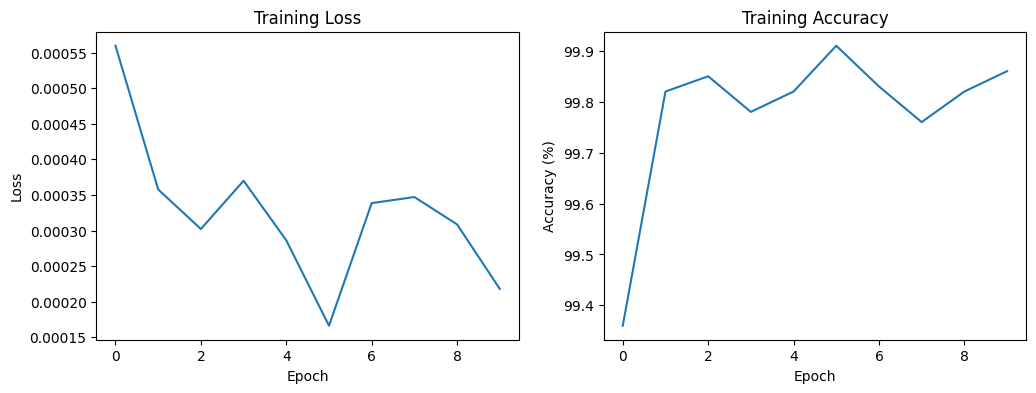

In [14]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [15]:
# define the final model
model_final = torch.nn.Sequential(
    model_Feature,
    torch.nn.Flatten(),
    model_fc
)

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, _,_,labels = data
        outputs = model_final(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train dataset:{100 * correct / total}')

Accuracy of the network on the train dataset:99.81


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_final(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset:{100 * correct / total}')

Accuracy of the network on the test dataset:97.0
